In [1]:
import pandas as pd
import numpy as np
import math


mat = pd.read_csv('student-mat.csv', sep=';')
por = pd.read_csv('student-por.csv', sep=';')

df = pd.concat([mat, por])

### Target
на основании данных из предикторов $Walc$ и $Dalc$, создаем атрибут $Alc$ - то что будем предсказывать

In [2]:
df['Alc'] = round((2*df['Walc'] + 5*df['Dalc'])/7)
df['Alc'] = df['Alc'].astype(int)

In [3]:
del df['Walc']
del df['Dalc']

### Preprocessing
Необходимо выполнить преобразование строковых значений атрибутов, в численные представления

In [4]:
from sklearn.preprocessing import LabelEncoder

cat = ['school', 'sex', 'address', 'famsize', 
       'Pstatus', 'schoolsup', 'famsup', 'paid', 
       'activities', 'nursery', 'higher', 'internet', 'romantic']

for c in cat:
    label = LabelEncoder()
    dicts = {}

    label.fit(df[c].drop_duplicates()) #задаем список значений для кодирования
    dicts[c] = list(label.classes_)
    df[c] = label.transform(df[c]) #заменяем значения из списка кодами закодированных элементов 

In [5]:
del df['Mjob']
del df['Fjob']
del df['reason']
del df['guardian']
# nominal = ['Mjob', 'Fjob', 'reason'] # , 'guardian'

# for c in nominal:
#     dummies = pd.get_dummies(df[c]).rename(columns=lambda x: c + '_' + str(x))
#     df = pd.concat([df, dummies], axis=1)
#     del df[c]

In [6]:
target = df.Alc
train = df.drop(['Alc'], axis=1) 

### Dimension Reduction
В виду ограничения на количество используемых предикторов, необходимо, используя некоторые соображения, удалить часть предикторов.

Ранее, часть предикторов уже была удалена на основании обычных рассуждений. 

Для того чтобы принять решение о том, какие предикторы можно удалить, было решено посчитать корреляцию между таргетом $Alc$ и предикторами 

In [7]:
import scipy as sp

headers = ['school', 'sex', 'age', 'address', 'famsize', 
           'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
           'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 
           'goout', 'health', 'absences', 
           'G1', 'G2', 'G3']

for h in headers:
    s = sp.stats.spearmanr(train[h], target)
    print(h, s[0], s[1])

school 0.0476234474369 0.12410000649
sex 0.315184534621 1.64640155327e-25
age 0.111809506276 0.000294941296315
address -0.0616257592034 0.0465143077656
famsize 0.100940480255 0.00109107459897
Pstatus 0.0560940717255 0.0700309828007
Medu -0.00753769560659 0.807802373074
Fedu 0.00997693625141 0.747462919119
traveltime 0.0543963820319 0.0789525652971
studytime -0.222091474138 3.92185784744e-13
failures 0.132467028655 1.75522777536e-05
schoolsup -0.0511870452167 0.0983295635989
famsup -0.0725802360338 0.0190054713251
paid 0.0446715175718 0.149197508249
activities 0.00508538136317 0.869638316989
nursery -0.0785964381258 0.0110720358812
higher -0.111626285832 0.000301818569715
internet 0.0420313252101 0.17476645346
romantic 0.0151975463811 0.623788751759
famrel -0.114137326318 0.000219407245161
freetime 0.160601518788 1.81965792189e-07
goout 0.348703390869 3.25630224243e-31
health 0.107102603893 0.000527437904946
absences 0.155255250105 4.6301494871e-07
G1 -0.178062529694 6.92072715739e-09
G

In [8]:
del train['failures']
del train['absences']
del train['G1']
del train['G2']
del train['G3']
del train['higher']
del train['famrel']

In [ ]:
# from sklearn.decomposition import PCA


# pca = PCA(n_components=10)
# pca.fit(train)
# train = pca.transform(train)

### Модели
* Random Forest
* kNN
* SVM
* NeuralNetwork

In [10]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

kfold = 5 
itog_val = {} 

In [11]:
model_rfc = RandomForestClassifier()
model_knc = KNeighborsClassifier()
model_svc = svm.SVC()

In [35]:
scores = cross_validation.cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RFC'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNN'] = scores.mean()
scores = cross_validation.cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVM'] = scores.mean()

### Результаты CV (20 предикторов)

In [33]:
print(itog_val)

{'KNN': 0.57346742277895979, 'RFC': 0.81225277223017134, 'SVM': 0.59011039990820924}


С помощью RandomForest, оценим то, какие предикторы являются важными для классификатора,
и, на основании полученных сведений, удалим некоторые предикторы

Feature ranking:
1. feature 18 - freetime (0.105318)
2. feature 2 - sex (0.096638)
3. feature 19 - goout (0.081774)
4. feature 17 - romantic (0.080038)
5. feature 6 - Pstatus (0.072107)
6. feature 7 - Medu (0.067632)
7. feature 9 - traveltime (0.066005)
8. feature 8 - Fedu (0.055952)
9. feature 1 - school (0.045102)
10. feature 4 - address (0.039283)
11. feature 13 - paid (0.039002)
12. feature 16 - internet (0.035080)
13. feature 0 - health (0.033634)
14. feature 11 - schoolsup (0.032513)
15. feature 14 - activities (0.031909)
16. feature 3 - age (0.031812)
17. feature 10 - studytime (0.022608)
18. feature 5 - famsize (0.021770)
19. feature 12 - famsup (0.021236)
20. feature 15 - nursery (0.020588)


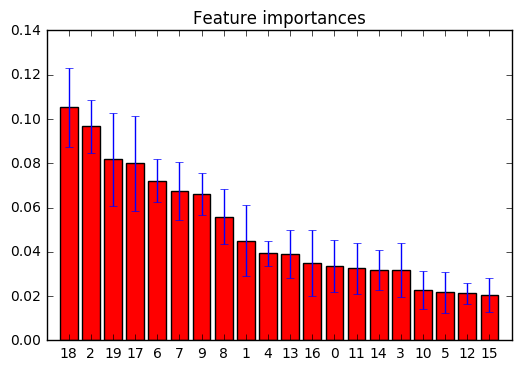

In [42]:
from matplotlib import pyplot as plt


model_rfc.fit(train, target)

importances = model_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

header = list(train.columns.values)

for f in range(train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], header[indices[f]-1],importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

In [43]:
del train['nursery']
del train['famsup']
del train['famsize']
del train['studytime']
del train['age']
del train['activities']
del train['schoolsup']
del train['health']
del train['internet']
del train['paid']

### Результаты CV (10 предикторов)
Из результатов видно, что удаление предикторов негативно скзалось на предсказывающей способности классификаторов

In [48]:
scores = cross_validation.cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RFC'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNN'] = scores.mean()
scores = cross_validation.cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVM'] = scores.mean()

print(itog_val)

{'KNN': 0.55894471343719632, 'RFC': 0.77680092331930306, 'SVM': 0.57372575148258864}


#### Neural Network

In [49]:
in_dim = 10
out_dim = 5

def labels_one_hot_encoding(labels):
    l = len(labels)
    tl = np.zeros((l, out_dim))
    tl[np.arange(l), labels-1] = 1
    return tl

Y_train = labels_one_hot_encoding(target)
X_train = train.as_matrix()

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD


def compile_model(model, learning_rate=0.1, d=1e-6):
    sgd = SGD(lr=learning_rate, decay=d) #, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['categorical_accuracy'])
    
    return model

def train_and_test_model(model, X_train, Y_train, bs=4, epoch=100):
    model.fit(X_train, Y_train, batch_size=bs, nb_epoch=epoch)

def model_nn():
    model = Sequential()
    model.add(Dense(10, input_dim=in_dim))
    model.add(Activation('tanh'))
    model.add(Dense(8))
    model.add(Activation('tanh'))
    model.add(Dense(out_dim))
    model.add(Activation('softmax'))

    return model

In [56]:
train_and_test_model(compile_model(model_nn()), X_train, Y_train, bs=16, epoch=200)

Epoch 1/200
1044/1044 [==============================] - 0s - loss: 1.1655 - categorical_accuracy: 0.5374     
Epoch 2/200
1044/1044 [==============================] - 0s - loss: 1.1242 - categorical_accuracy: 0.5354     
Epoch 3/200
1044/1044 [==============================] - 0s - loss: 1.0957 - categorical_accuracy: 0.5345     
Epoch 4/200
1044/1044 [==============================] - 0s - loss: 1.0856 - categorical_accuracy: 0.5393     
Epoch 5/200
1044/1044 [==============================] - 0s - loss: 1.0765 - categorical_accuracy: 0.5441     
Epoch 6/200
1044/1044 [==============================] - 0s - loss: 1.0703 - categorical_accuracy: 0.5489     
Epoch 7/200
1044/1044 [==============================] - 0s - loss: 1.0633 - categorical_accuracy: 0.5527     
Epoch 8/200
1044/1044 [==============================] - 0s - loss: 1.0537 - categorical_accuracy: 0.5603     
Epoch 9/200
1044/1044 [==============================] - 0s - loss: 1.0607 - categorical_accuracy: 0.5527     
E

### Визуализация
Была выполнена попытка визуализировать данные на плоскости. Никаких содерательных выводов, на основании полученной визуализации, сделать не удалось.

In [59]:
from sklearn.decomposition import PCA


model_pca = PCA(n_components=2)
vis_data = model_pca.fit_transform(train) 

Populating the interactive namespace from numpy and matplotlib


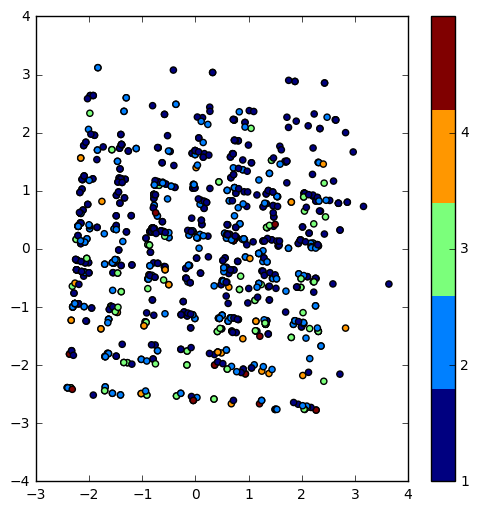

In [61]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=target, cmap=plt.cm.get_cmap("jet", 5))
plt.colorbar(ticks=range(5))
plt.clim(1, 5)
plt.show()

### Вывод
По результатам тестирования, лучшим классификатором оказался Random Forest